In [1]:
import os,sys

currentdir = os.getcwd()
parentdir = os.path.dirname(currentdir)
gparentdir = os.path.dirname(parentdir)

prototypedir = '/'.join([gparentdir,'prototyping']) 
minionsdir = '/'.join([gparentdir,'minions']) 

sys.path.insert(0, gparentdir) 
sys.path.insert(0, prototypedir) 
sys.path.insert(0, minionsdir) 
sys.path.insert(0, '/'.join([parentdir,'Functions','Procedures'])) 

from prototyping.util import *

from DetermineRidges.RidgeAnalysis import PolylineGraphs,LabelledMesh

In [2]:

def geodesic_cut (mesh):

    mesh.tri_mesh.submesh()

def create_adjacent_label_submeshes (mesh,edges):

    """
    Creates submeshes of mesh according to passed labels. 
    
    Args:
        mesh (trimesh object): trimesh mesh object
        edges (dict): A dictionary containing edges (keys) and vertex ID's (values).             

    Returns: 
        submeshes (dict): A dictionary of submeshes of the labelled adjacency meshes.

    """ 
    
    selected_faces =   {   label:
                                    np.all(np.isin(mesh.faces,values), axis=1)
                                for label,values in edges.items()
                            }

    # print(selected_faces)
    # print(edges)

    submeshes = {   label:
                            mesh.submesh([selected_faces[label]])
                        for label in edges.keys()
                    }

    return submeshes


In [2]:
from Paths import Paths

def find_edges_vertices(edges,labels):

    """
    Creates submeshes of mesh according to passed labels. 
    
    Args:
        mesh (trimesh object): trimesh mesh object
        edges (dict): A dictionary containing edges (keys) and vertex ID's (values).             

    Returns: 
        edge_vertices (dict): A dictionary of submeshes of the labelled adjacency meshes.

    """ 

    labels_vertices = get_uniquelabel_vertlist(labels)

    edges_vertices = {edge:[vert for label in edge for vert in labels_vertices[label]] for edge in edges}

    return edges_vertices

def edges_submeshes (mesh,labels,edges):

    """
    Creates submeshes of mesh according to passed labels. 
    
    Args:
        mesh (trimesh object): trimesh mesh object
        labels (dict): dictionary containing unique_labels (keys) and vertex ID's (values).   
        edge (tuple): tuple containing the selected edge.

    Returns: 
        edges_submeshes (dict): dictionary of edge submeshes of the original labelled meshes.

    """    

    edges_vertices = find_edges_vertices (edges,labels)
    
    selected_faces =   {   edge:
                                    np.all(np.isin(mesh.faces,values), axis=1)
                                for edge,values in edges_vertices.items()
                            }
    
    edges_submeshes = {   edge:
                            mesh.submesh([selected_faces[edge]])[0]
                        for edge in edges
                    }

    return edges_submeshes


from prototyping.Functions.EssentialMeshAlteration import create_label_submeshes

from prototyping.Functions.EssentialLabelAlteration import  get_uniquelabel_vertlist



In [7]:
from prototyping.Functions.main import labelledmesh_procedures,label_slice_procedure

preprocessed = '_GMOCF_r1.00_n4_v256.volume'
exp_path = 'exp_path'
ind = str(207)
labelname = '_gt_labels'#'_Kmeans_labels'#

manu_type = 'edges'
path = "/home/linsel/Documents/PhD/Data/Graphs/Fumane/CO/{}/".format(ind)
ending = '.txt'

labelfilepath = ''.join([path,ind,labelname,ending])

kwargs = {  'path': path,
            'id':ind,
            'preprocessed':preprocessed,
            'labelname':labelname,
            'labelfilepath':labelfilepath,
            'manu_type': manu_type,
            'exp_path':exp_path
            }



In [3]:
from Classes.BasicClasses import manualEdges



def get_manual_edges (**kwargs):
    id = kwargs['id']
    path = kwargs['path']
    manu_type = kwargs['manu_type']

    mE = manualEdges()
    if manu_type == 'edges':
        mE.import_edges(path, id )
        
    elif manu_type == 'edges_nodes':
        mE.import_edges_nodes(path, id )

    else:
        print('no reference for edges provided')
        return          

    return mE.manual_edges

def create_shortest_path (obj,
                selected_edges: dict,
                **kwargs
                ) -> object:

    """
    A Mesh object contains a triangular 3D mesh.

    Args:
        path (str): String representing the path to the file.
        id (str): String representing the file id of the ply file.
        preprocessed (str): String representing the preprocessing stage of the ply file.
        exp_path (str): String representing the export folder where to save all derived data.
        selected_edges (dict): dictionary containing edge label (key) e.g. node ids in graph, and selection of vertex ids (value).
    """

    # check for None only to avoid warning messages in subclasses
    obj.path = kwargs['path']
    obj.id = kwargs['id']
    obj.preprocessed = kwargs['preprocessed']
    obj.exp_path = kwargs['exp_path']

    obj.selected_edges = selected_edges # kwargs ['selected_edges']       

    obj.tri_mesh = trimesh.load(''.join([obj.path, obj.id, obj.preprocessed, '.ply']))
    obj.shortest_paths()          

def shortest_path_procedure (obj,**kwargs):

    LM = LabelledMesh ()
    
    label_slice_procedure(LM,**kwargs)

    LM.get_NNs_ids()

    manual_edges = get_manual_edges (**kwargs)

    edges_NNs = {(s,t):(LM.NNs_ids [s],LM.NNs_ids [t]) for s,t in manual_edges}

    create_shortest_path(obj,
        edges_NNs,
        **kwargs)

    return obj


In [12]:

def path_procedures (method,**kwargs):

    P = Paths()

    procedures = {'shortest_path':shortest_path_procedure}

    func = procedures.get(method)

    P = func(P,**kwargs)

    return P    

P = path_procedures('shortest_path',**kwargs)

P.shortest_paths

KeyError: 'selected_edges'

In [7]:
from Functions.BasicMSII1D import angle_between_vectors

def get_NNs_ids (tri_mesh,points):

    """
    Creates a dictionary containing labels (key) and nearest neighbor to label centroid as vertex id (values). 
    """

    # Nearest neighbour (NN) from label centroid to submesh        
    NNs_ids = {} 
                            
    for label, p in points.items():

        _,index = tri_mesh.kdtree.query(p)

        NNs_ids [label] = index

    return NNs_ids

def eigenvector (X):
    C = np.dot(X.T,X)
    eigval, eigvec = np.linalg.eigh(C)
    sortid = eigval.argsort()[::-1]

    eigvec = eigvec[:,sortid]

    return eigvec

def qsort(inlist):
    if inlist == []: 
        return []
    else:
        pivot = inlist[0]
        lesser = qsort([x for x in inlist[1:] if x < pivot])
        greater = qsort([x for x in inlist[1:] if x >= pivot])
        return lesser + [pivot] + greater
    
######################
# mesh transformations 
def mesh_transform_two_vertices(tri, verts):

    tri.vertices = tri.vertices - verts[0]

    verts[1] = verts[1] - verts[0]

    verts[0] = verts[0] - verts[0]

    # triverts = tri.vertices - tri.vertices[131587]
    dist = float(distance.euclidean(verts[0],verts[1]))

    _,trafo_mat = angle_between_vectors(np.array(verts[1]), 
                                        np.array([0,0,0]), 
                                        np.array([dist, 0,0])
                                        )

    trafo_mat = np.c_[np.c_[trafo_mat.T, np.array([0,0,0])].T,np.array([0,0,0,0])]

    tri.apply_transform(trafo_mat)    

    return tri, trafo_mat 


######################
    

def create_lines_graph(tri,vert_ids,lines):

    lines_set = {tuple(line[0]) for line in lines}

    [lines_set.add(tuple(line[1])) for line in lines]

    lines_list = []

    [lines_list.append(tuple(lin)) for line in lines for lin in line] 

    count = {lin:lines_list.count(lin) for _,lin in enumerate(lines_set)}

    print([lin for lin,c in count.items() if c == 1])

    lines_dict = {v:n for n, v in enumerate(lines_set)} 

    lines_dict_inv = {v: np.array(k) for k, v in lines_dict.items()}

    length = [distance.euclidean(line[0],line[1]) for line in lines]

    source = lines_dict[tuple(tri.vertices[vert_ids[0]])] #([n for n,line in enumerate(lines) if list(line[0]) == list(verts[0]))

    # lines_dict tri.vertices[vert_ids[1]]

    print(min([distance.euclidean(tri.vertices[vert_ids[1]],np.array(v)) for v in lines_dict.keys()]))

    target = lines_dict[tuple(tri.vertices[vert_ids[1]])] #= max([n for n,line in enumerate(lines) if list(line[0]) == list(tri.vertices[vert_ids[1]])])

    print(target)

    G = nx.Graph()
    for edge, L in zip(lines, length):

        edge_id = (lines_dict [tuple(edge[0])],lines_dict [tuple(edge[1])]) #(lines_dict [tuple(edge[0])],lines_dict [tuple(edge[1])])
        G.add_edge(*edge_id, length=L)    

    return G
    
def add_edges_from_faces (tri,G,face):

    for c in [(0,1),(1,2),(2,0)]:

        edge = tuple((face[c[0]],face[c[1]]))
        length = distance.euclidean (tri.vertices [edge[0]], tri.vertices [edge[1]])
        G.add_edge(*edge,length = length)    
    
    return G

def increase_path_size (tri,face_verts,selected_face_verts):

    for n,values in enumerate(face_verts):

        faces_list = list(tri.faces[np.any(np.isin(tri.faces,values), axis=1)])
        faces_list = [list(face) for face in faces_list]
        faces_list = [vert for vert in faces_list]

        [selected_face_verts.add (tuple(vert)) for vert in faces_list ]

        # [selected_face_verts.add (tuple(face)) for faces in faces_list for face in list(faces)]

        # for faces in faces_list:
        #     for face in faces:
        #         selected_face_verts.add (tuple(face))
            
    faces_dict = {tuple(face):n for n,face in enumerate(tri.faces)}

    selected_faces = {faces_dict[face] for face in selected_face_verts}

    return selected_face_verts,selected_faces

def shortest_distance(tri,vert_ids,selected_faces):

    G = nx.Graph()
    for face_id in selected_faces:

        face = tri.faces[face_id]

        G = add_edges_from_faces(tri,G,face)                                               


    shortest_paths = nx.shortest_path(G,
                                    source=vert_ids[0],                                        
                                    target=vert_ids[1],                                        
                                    weight='length')     


    shortest_paths_dist = np.sum([G.edges[(v,int(shortest_paths[n+1]))]['length'] for n,v in enumerate(shortest_paths[:-1])])

    return shortest_paths, shortest_paths_dist

def path_profile (self):
    
    tri = self.tri_mesh.copy()

    path_profiles = {}

    for edge_ids, vert_ids in self.selected_edges.items():

        verts = {0:tri.vertices[vert_ids[0]], 
                 1:tri.vertices[vert_ids[1]]}
        
        mesh_transform_two_vertices(tri, verts)

        # align_mesh_principal_component(tri)

        lines,faces = trimesh.intersections.mesh_plane(tri,[0,1,0],[0,0,0],return_faces=True)

        # creates a line graph, which is not sufficient to build a complete cycle graph
        # create_lines_graph ()
        
        face_verts = set()
        G = nx.Graph()
        for face_id in faces:

            face = tri.faces[face_id]

            G = add_edges_from_faces(tri,G,face)

            [face_verts.add (vert) for vert in face]
 

        try:
            shortest_paths = nx.shortest_path(G,
                                            source=vert_ids[0],                                        
                                            target=vert_ids[1],                                        
                                            weight='length')     


            shortest_paths_dist = np.sum([G.edges[(v,int(shortest_paths[n+1]))]['length'] for n,v in enumerate(shortest_paths[:-1])])

        except:
            selected_face_verts = set()
            try:
                selected_face_verts,selected_faces = increase_path_size (tri,face_verts,selected_face_verts)
                shortest_paths, shortest_paths_dist = shortest_distance(tri,vert_ids,selected_faces)
            except:
                try:
                    selected_face_verts,selected_faces = increase_path_size (tri,face_verts,selected_face_verts)
                    shortest_paths, shortest_paths_dist = shortest_distance(tri,vert_ids,selected_faces)
                except:
                    shortest_paths, shortest_paths_dist = 0,0
                    print(edge_ids)


            # selected_face_verts = set()
            # for n,values in enumerate(face_verts):

            #     faces_list = list(tri.faces[np.any(np.isin(tri.faces,values), axis=1)])
            #     faces_list = [list(face) for face in faces_list]
            #     faces_list = [vert for vert in faces_list]

            #     [selected_face_verts.add (tuple(vert)) for vert in faces_list ]

            #     if n % 10000 == 0:
            #         print(n)

            #     # [selected_face_verts.add (tuple(face)) for faces in faces_list for face in list(faces)]

            #     # for faces in faces_list:
            #     #     for face in faces:
            #     #         selected_face_verts.add (tuple(face))
                    
            # faces_dict = {tuple(face):n for n,face in enumerate(tri.faces)}

            # selected_faces = {faces_dict[face] for face in selected_face_verts}
                                                        
            # G = nx.Graph()
            # for face_id in selected_faces:

            #     face = tri.faces[face_id]

            #     G = add_edges_from_faces(tri,G,face)

            #     {vert for vert in face} 

            # shortest_paths = nx.shortest_path(G,
            #                                 source=vert_ids[0],                                        
            #                                 target=vert_ids[1],                                        
            #                                 weight='length')     


            # shortest_paths_dist = np.sum([G.edges[(v,int(shortest_paths[n+1]))]['length'] for n,v in enumerate(shortest_paths[:-1])])


        path_profiles [edge_ids] =  {'path':shortest_paths,'dist':shortest_paths_dist}
        
        
        # cycle_length = [distance.euclidean(lines_dict_inv[line[0]],lines_dict_inv[line[1]]) for n,line in enumerate(g_cycle_edges)]

        # g_cycle = nx.Graph()
        # for edge, L in zip(g_cycle_edges, cycle_length):
        #     edge_id = (lines_dict_inv [edge[0]],lines_dict_inv [edge[1]]) #(lines_dict [tuple(edge[0])],lines_dict [tuple(edge[1])])
        #     g.add_edge(*edge_id, length=L)        

        # shortest_paths = {}
        # # run the shortest path query using length for edge weight

        # shortest_paths = nx.shortest_path(g,
        #                                   source=source,                                        
        #                                   target=target,                                        
        #                                   weight='length') 
        

        # simple_paths = nx.all_simple_paths (g, source, target, cutoff=20)

        # print()
        
        # # print([len(path) for path in nx.all_shortest_paths (g, source, target)])
        # for path in simple_paths:
        #     print(len(path)) 
        
        
        # run the shortest path query using length for edge weight
    
        # shortest_paths_dist = np.sum([g.edges[(v,int(shortest_paths[n+1]))]['length'] for n,v in enumerate(shortest_paths[:-1])])

        # 
        # print(shortest_paths_dist)

    return path_profiles

# P.selected_edges = {(3,4): tuple(NNs_ids.keys())}
# print(P.selected_edges)



In [8]:
path_profiles = path_profile(P)

(3, 8)


In [9]:
def transform_two_vertices_second(tri, verts):

    _,trafo_mat = angle_between_vectors(np.array(verts[1]), 
                                        np.array([0,0,0]), 
                                        np.array([verts[0]])
                                        )

    trafo_mat = np.c_[np.c_[trafo_mat.T, np.array([0,0,0])].T,np.array([0,0,0,0])]

    tri.apply_transform(trafo_mat)    

    return tri, trafo_mat 


def rotate_x_mean_vector (v1,v2):
    return (v1 [1:] + v2[1:]) / 2


In [4]:
def align_mesh_principal_component(mesh,submesh):

    """
    Rotate the coordinates to align its principal components of the y and z axis.
    
    Parameters:
    - mesh: trimesh.Trimesh, the mesh to align.
    
    Returns:
    - mesh: trimesh.Trimesh, the aligned mesh.
    """

    # select the y and z axis of the passed meshes vertices
    coords = submesh.vertices[:,1:]
    
    # Calculate the covariance matrix of the mesh vertices
    covariance_matrix = np.cov(coords, rowvar=False)
    
    # Compute eigenvalues and eigenvectors
    _, eigenvectors = np.linalg.eig(covariance_matrix)

    trafo_mat = np.array([[1,0,0,0],
    [0,eigenvectors[0,0],eigenvectors[0,1],0],
    [0,eigenvectors[1,0],eigenvectors[1,1],0],
    [0,0,0,1]])

    mesh.apply_transform (trafo_mat)

def align_mesh_mean_normal(mesh,submesh):

    """
    Rotate the coordinates to align its principal components of the y and z axis.
    
    Parameters:
    - mesh: trimesh.Trimesh, the mesh to align.
    
    Returns:
    - mesh: trimesh.Trimesh, the aligned mesh.
    """

    # select the y and z axis of the passed meshes vertices

    P.tri_mesh.vertex_normals
    coords = submesh.vertices[:,1:]
    
    # Calculate the covariance matrix of the mesh vertices
    covariance_matrix = np.cov(coords, rowvar=False)
    
    # Compute eigenvalues and eigenvectors
    _, eigenvectors = np.linalg.eig(covariance_matrix)

    trafo_mat = np.array([[1,0,0,0],
    [0,eigenvectors[0,0],eigenvectors[0,1],0],
    [0,eigenvectors[1,0],eigenvectors[1,1],0],
    [0,0,0,1]])

    mesh.apply_transform (trafo_mat)



P.create_edges_submeshes (LM.dict_label)

# path_turned_profile (P)

NameError: name 'P' is not defined

In [5]:
import numpy as np 



In [15]:
np.dot([0.5,90],[1,0])

ValueError: shapes (4,) and (2,) not aligned: 4 (dim 0) != 2 (dim 0)

In [30]:

from scipy.spatial.distance import euclidean
      
def path_turned_profile (self):

    tri = self.tri_mesh.copy () 
    
    path_profiles = {}

    for edge_ids, vert_ids in self.selected_edges.items():

        verts = {0:tri.vertices[vert_ids[0]], 
                 1:tri.vertices[vert_ids[1]]}
        
        print(verts)
        break
        tri, trafo_mat = mesh_transform_two_vertices(tri, verts)

        submesh = self.edges_submeshes [edge_ids].copy()
        submesh.apply_transform(trafo_mat)

        align_mesh_principal_component(tri,submesh)

        lines,faces = trimesh.intersections.mesh_plane(tri,[0,1,0],[0,0,0],return_faces=True)

        # creates a line graph, which is not sufficient to build a complete cycle graph
        # create_lines_graph ()
        
        face_verts = set()
        G = nx.Graph()
        for face_id in faces:

            face = tri.faces[face_id]

            G = add_edges_from_faces(tri,G,face)

            [face_verts.add (vert) for vert in face]
 

        try:
            shortest_paths = nx.shortest_path(G,
                                            source=vert_ids[0],                                        
                                            target=vert_ids[1],                                        
                                            weight='length')     


            shortest_paths_dist = np.sum([G.edges[(v,int(shortest_paths[n+1]))]['length'] for n,v in enumerate(shortest_paths[:-1])])

        except:
            selected_face_verts = set()
            try:
                selected_face_verts,selected_faces = increase_path_size (tri,face_verts,selected_face_verts)
                shortest_paths, shortest_paths_dist = shortest_distance(tri,vert_ids,selected_faces)
            except:
                try:
                    selected_face_verts,selected_faces = increase_path_size (tri,face_verts,selected_face_verts)
                    shortest_paths, shortest_paths_dist = shortest_distance(tri,vert_ids,selected_faces)
                except:
                    shortest_paths, shortest_paths_dist = 0,0
                    print(edge_ids)

        path_profiles [edge_ids] =  {'path':shortest_paths,'dist':shortest_paths_dist}

    return path_profiles

def path_mean_profile (self):

    tri = self.tri_mesh.copy () 
    
    path_profiles = {}

    for edge_ids, vert_ids in self.selected_edges.items():

        verts = {0:tri.vertices[vert_ids[0]], 
                 1:tri.vertices[vert_ids[1]]}
        
        tri, trafo_mat = mesh_transform_two_vertices(tri, verts)

        submesh = self.edges_submeshes [edge_ids].copy()
        submesh.apply_transform(trafo_mat)

        align_mesh_principal_component(tri,submesh)

        lines,faces = trimesh.intersections.mesh_plane(tri,[0,1,0],[0,0,0],return_faces=True)

        # creates a line graph, which is not sufficient to build a complete cycle graph
        # create_lines_graph ()
        
        face_verts = set()
        G = nx.Graph()
        for face_id in faces:

            face = tri.faces[face_id]

            G = add_edges_from_faces(tri,G,face)

            [face_verts.add (vert) for vert in face]
 

        try:
            shortest_paths = nx.shortest_path(G,
                                            source=vert_ids[0],                                        
                                            target=vert_ids[1],                                        
                                            weight='length')     


            shortest_paths_dist = np.sum([G.edges[(v,int(shortest_paths[n+1]))]['length'] for n,v in enumerate(shortest_paths[:-1])])

        except:
            selected_face_verts = set()
            try:
                selected_face_verts,selected_faces = increase_path_size (tri,face_verts,selected_face_verts)
                shortest_paths, shortest_paths_dist = shortest_distance(tri,vert_ids,selected_faces)
            except:
                try:
                    selected_face_verts,selected_faces = increase_path_size (tri,face_verts,selected_face_verts)
                    shortest_paths, shortest_paths_dist = shortest_distance(tri,vert_ids,selected_faces)
                except:
                    shortest_paths, shortest_paths_dist = 0,0
                    print(edge_ids)

        path_profiles [edge_ids] =  {'path':shortest_paths,'dist':shortest_paths_dist}

    return path_profiles


# path_turned_profile (P)

# for edge,param in path_profiles.items():

#     plt.hist(P.shortest_paths_dist[edge] - param ['dist'])  


ValueError: shapes (3,) and (1,3) not aligned: 3 (dim 0) != 1 (dim 0)

In [8]:
def rotation_matrix_x(theta):
    """
    Create a 3D rotation matrix around the X-axis.

    Parameters:
        theta (float): Angle of rotation in radians.

    Returns:
        numpy.ndarray: 3x3 rotation matrix.
    """
    return np.array([[1, 0, 0],
                     [0, np.cos(theta), -np.sin(theta)],
                     [0, np.sin(theta), np.cos(theta)]])

def vector_rotation_matrix(v1, v2):
    """
    Create a transformation matrix to rotate v1 to align with v2 around the X-axis.

    Parameters:
        v1 (numpy.ndarray): Initial vector.
        v2 (numpy.ndarray): Target vector.

    Returns:
        numpy.ndarray: Transformation matrix.
    """
    v1_unit = v1 / np.linalg.norm(v1)  # Normalize v1
    v2_unit = v2 / np.linalg.norm(v2)  # Normalize v2

    dot_product = np.dot(v1_unit, v2_unit)
    angle = np.arccos(dot_product)  # Angle between v1 and v2

    if not np.isclose(angle, 0):
        axis = np.cross(v1_unit, v2_unit)  # Axis of rotation
        axis /= np.linalg.norm(axis)  # Normalize axis
        rotation_matrix = rotation_matrix_x(angle)  # Rotation around X-axis
        return rotation_matrix
    else:
        return np.eye(3)  # No rotation needed

def transform_normals(tri, verts):

    trafo_mat = vector_rotation_matrix(verts[1], 
                                        verts[0])

    trafo_mat = np.c_[np.c_[trafo_mat.T, np.array([0,0,0])].T,np.array([0,0,0,0])]

    tri.apply_transform(trafo_mat)    

    return tri, trafo_mat 


def path_turned_profile_normal (self):

    tri = self.tri_mesh.copy () 
    
    path_profiles = {}

    for edge_ids, vert_ids in self.selected_edges.items():

        verts = {0:tri.vertices[vert_ids[0]], 
                 1:tri.vertices[vert_ids[1]]}
        

        tri, trafo_mat = mesh_transform_two_vertices(tri, verts)

        print(trafo_mat)

        # tri.apply_transform(trafo_mat)

        # align_mesh_principal_component(tri,submesh)

        mean_normal = rotate_x_mean_vector (tri.vertex_normals[vert_ids[0]],
                                            tri.vertex_normals[vert_ids[1]])
        
        v = np.hstack([np.array([0]),mean_normal * 1 / euclidean ([0,0],mean_normal)])
      
        verts = {   1:[0,1,0],
                    0:[n for n in v]}

        submesh = self.edges_submeshes [edge_ids].copy()

        submesh.apply_transform(trafo_mat)
        submesh, trafo_mat = transform_normals (submesh, verts)

        print(trafo_mat)
        
        submesh.apply_transform(trafo_mat)

        lines,faces = trimesh.intersections.mesh_plane(submesh,[0,1,0],[0,0,0],return_faces=True)
        
        face_verts = set()
        G = nx.Graph()
        for face_id in faces:

            face = tri.faces[face_id]

            G = add_edges_from_faces(tri,G,face)

            [face_verts.add (vert) for vert in face]
 

        try:
            shortest_paths = nx.shortest_path(G,
                                            source=vert_ids[0],                                        
                                            target=vert_ids[1],                                        
                                            weight='length')     


            shortest_paths_dist = np.sum([G.edges[(v,int(shortest_paths[n+1]))]['length'] for n,v in enumerate(shortest_paths[:-1])])

        except:
            selected_face_verts = set()
            try:
                selected_face_verts,selected_faces = increase_path_size (tri,face_verts,selected_face_verts)
                shortest_paths, shortest_paths_dist = shortest_distance(tri,vert_ids,selected_faces)
            except:
                try:
                    selected_face_verts,selected_faces = increase_path_size (tri,face_verts,selected_face_verts)
                    shortest_paths, shortest_paths_dist = shortest_distance(tri,vert_ids,selected_faces)
                except:
                    shortest_paths, shortest_paths_dist = 0,0
                    print(edge_ids)

        path_profiles [edge_ids] =  {'path':shortest_paths,'dist':shortest_paths_dist}

    return path_profiles        
  

path_turned_profile_normal (P)



NameError: name 'P' is not defined

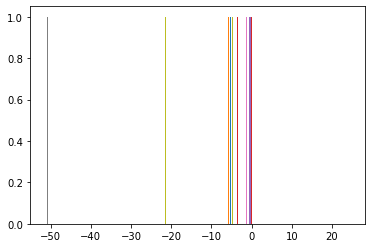

In [ ]:
for edge,param in path_profiles.items():

    plt.hist(P.shortest_paths_dist[edge] - param ['dist'])

(3, 8)
(3, 14)
(3, 8)


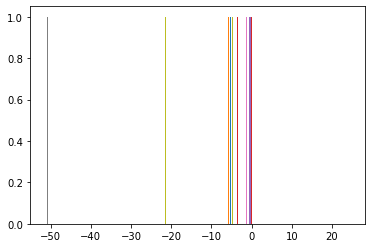

In [18]:
import matplotlib.pyplot as plt
import numpy as np

path_turned_profile (P) 

for edge,param in path_profiles.items():

    plt.hist(P.shortest_paths_dist[edge] - param ['dist'])

(3, 8)
(3, 14)
(3, 8)


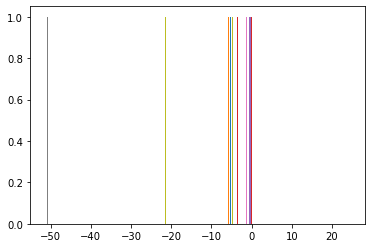

In [19]:
path_mean_profile (P) 
path_profiles = path_profile(P)
for edge,param in path_profiles.items():

    plt.hist(P.shortest_paths_dist[edge] - param ['dist'])

(3,) [0.0, 0.07081168937812758, 0.9974897015244898]


ValueError: shapes (3,) and (1,3) not aligned: 3 (dim 0) != 1 (dim 0)

In [16]:
from Functions.EssentialLabelAlteration import get_uniquelabel_vertlist

labels = get_uniquelabel_vertlist (LM.dict_label)

[[edge,param['dist']] for edge, param in path_profiles.items()]
create_edges_submeshes (mesh,labels,edge)

NameError: name 'path_profiles' is not defined

In [109]:
# [[edge,param['dist']] for edge, param in path_profiles.items()]
path_verts = [param['path'] for edge, param in path_profiles.items() if type (param['path']) != int] # if len (verts) != 0
path_verts = [v for verts in path_verts for v in verts]

path_verts

para_dict = {n:1 for n,_ in enumerate(LM.vertices)}

for v in path_verts:

    para_dict[v] = 2

path_verts = [param for edge, param in P.shortest_paths.items()] # if len (verts) != 0
path_verts = [v for verts in path_verts for v in verts]    

for v in path_verts:

    para_dict[v] = 3


para_dict

{0: 1,
 1: 1,
 2: 1,
 3: 2,
 4: 1,
 5: 1,
 6: 1,
 7: 1,
 8: 1,
 9: 1,
 10: 1,
 11: 1,
 12: 1,
 13: 1,
 14: 1,
 15: 1,
 16: 1,
 17: 1,
 18: 1,
 19: 1,
 20: 1,
 21: 1,
 22: 1,
 23: 1,
 24: 1,
 25: 1,
 26: 1,
 27: 1,
 28: 3,
 29: 1,
 30: 1,
 31: 1,
 32: 1,
 33: 1,
 34: 1,
 35: 1,
 36: 1,
 37: 1,
 38: 1,
 39: 1,
 40: 1,
 41: 1,
 42: 1,
 43: 1,
 44: 1,
 45: 1,
 46: 1,
 47: 1,
 48: 1,
 49: 1,
 50: 1,
 51: 1,
 52: 1,
 53: 1,
 54: 1,
 55: 1,
 56: 1,
 57: 1,
 58: 1,
 59: 1,
 60: 1,
 61: 1,
 62: 1,
 63: 1,
 64: 1,
 65: 1,
 66: 1,
 67: 1,
 68: 1,
 69: 1,
 70: 1,
 71: 1,
 72: 1,
 73: 1,
 74: 1,
 75: 1,
 76: 1,
 77: 1,
 78: 1,
 79: 1,
 80: 1,
 81: 1,
 82: 1,
 83: 1,
 84: 1,
 85: 1,
 86: 1,
 87: 1,
 88: 1,
 89: 1,
 90: 1,
 91: 1,
 92: 1,
 93: 1,
 94: 1,
 95: 1,
 96: 1,
 97: 1,
 98: 1,
 99: 1,
 100: 1,
 101: 1,
 102: 1,
 103: 1,
 104: 1,
 105: 1,
 106: 1,
 107: 1,
 108: 1,
 109: 1,
 110: 1,
 111: 1,
 112: 1,
 113: 1,
 114: 1,
 115: 1,
 116: 1,
 117: 1,
 118: 1,
 119: 1,
 120: 1,
 121: 1,
 122: 1,
 12

In [110]:
# from minions.MeshTxtMinions import write_func_vals_file

def write_func_vals_header(file:object, 
                            func_val:str):

    '''
    Write header for text file containing a vertices and fuction values.

    Args: 
        file (object): passed file object of an text file.
        func_val(str): name of the function value.
    
    '''

    file.write("# +-----------------------------------------------------+\n")
    file.write("# | txt file with funvals ({}){}|\n".format(
                                                                func_val,
                                                                ''.join([' '] * (28 - len(func_val)))
                                                            )
               )
    file.write("# +-----------------------------------------------------+\n")
    file.write("# | Format: index funval                                |\n")
    file.write("# +-----------------------------------------------------+\n")

def write_func_vals_file(func_vals_dict:dict, 
                         target_file:str, 
                         ending:str):

    '''
    Write text file containing a vertices and fuction values.    

    Args: 
        func_vals_dict (dict): dictionary containing two entries. 
            First, 'name' (key): name of the passed parameter (value). 
            Second, 'values' (key) and a nested dictionary (value) with vertex ids (keys) and function values (values)

        target_file (str): path and name of the text file. 
        ending (str): ending of the exported text file.
    '''    

    # open text file 
    f = open(''.join([target_file, ending]), "w")

    # add header to text file 
    write_func_vals_header(f,func_vals_dict['name'])
    
    # write function values
    for index,funval in func_vals_dict['values'].items():
        f.write(''.join([ str(index),' ',str(funval),'\n']))


label_name = 'paths'
para = {'values':para_dict,'name':'-shortest'}

write_func_vals_file (   para,
                        ''.join ([   path, 
                                    id,
                                    '_'.join([label_name,
                                                para['name']])
                                ]),
                        ending        
                    )




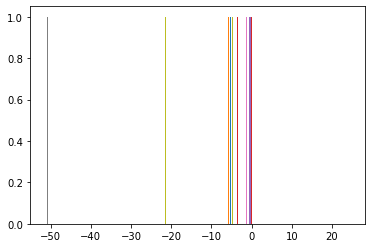

: 

In [48]:
NNs_ids = LM.NNs_ids
edges_NNs = {(s,t):(NNs_ids [s],NNs_ids [t]) for s,t in selected_edges}

P = Paths(path,
      id,
      preprocessed,
      exp_path,
      LM.tri_mesh,
      edges_NNs)

P.shortest_paths()

P.shortest_paths_dist

{(3, 4): 8.036998161836785,
 (3, 1): 14.913753445191388,
 (4, 6): 6.38311097150588,
 (3, 10): 36.38599996566131,
 (3, 16): 14.331221135171997,
 (3, 13): 14.491625497918928,
 (3, 19): 11.204221634463613,
 (3, 25): 9.470511971063479,
 (5, 10): 3.460787081741411,
 (8, 9): 1.7450994468220045,
 (3, 22): 22.05240654417109,
 (14, 13): 2.4351315899152457,
 (1, 9): 20.174425269989293,
 (1, 12): 23.769783569659758,
 (1, 18): 19.353573420665185,
 (25, 19): 1.9836007559016606,
 (1, 15): 10.066607305180693,
 (1, 21): 15.362419119003563,
 (6, 5): 25.313411326476405,
 (1, 24): 9.65151576623194,
 (18, 19): 1.686758135623203,
 (6, 23): 22.665795148228284,
 (4, 5): 27.109611804747953,
 (3, 12): 17.312716053864275,
 (3, 18): 12.216052518442638,
 (13, 21): 2.563687053125109,
 (3, 15): 9.633792171758278,
 (3, 21): 16.898493153694993,
 (14, 15): 3.0230661775569128,
 (3, 24): 5.287609239939428,
 (2, 1): 13.032356257213484,
 (2, 7): 13.298887050095223,
 (8, 17): 1.7864775762521448,
 (1, 11): 25.35476676115747

In [9]:
def shortest_path_procedure(obj,**kwargs):
    path = kwargs ['path'] 
    id = kwargs ['id']
    preprocessed = kwargs ['preprocessed']
    labelname = kwargs ['labelname']
    exp_path = kwargs ['exp_path'] 

    obj.load_labelled_mesh(path,id,preprocessed,labelname,exp_path) 

    obj.get_label_submeshes()

    obj.extract_ridges()

    # create node coordinates
    obj.get_centroids()


def shortest_path (obj,**kwargs):
    pass


def paths_procedures (method,**kwargs):
   
    P = Paths()

    procedures = {'shortest_path':shortest_path_procedure}

    func = procedures.get(method)

    func(P,**kwargs)

    return P    

    # 

    # return P


paths_procedures (shortest_path,**kwargs)

TypeError: 'NoneType' object is not callable